## Analyze 3 Million Grocery Orders Data with Spark

### Import Python libraries

In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

### Load normalized csv data

In [2]:
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
products = pd.read_csv('data/products.csv')
orders = pd.read_csv('data/orders.csv')
order_detail_small = pd.read_csv('data/order_products__train.csv')

### Preview normalized data

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_detail_small.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Analyze Data in Apache Spark

#### Load data into Spark as SparkDataFrame

In [8]:
spark = SparkSession.builder \
    .master("local") \
    .appName("InstacartData") \
    .getOrCreate()

In [9]:
df_aisles = spark.createDataFrame(aisles)
df_departments = spark.createDataFrame(departments)
df_products = spark.createDataFrame(products)
df_orders = spark.createDataFrame(orders)
df_order_detail = spark.createDataFrame(order_detail_small)

In [10]:
%matplotlib inline

#### What hour of day do people usually order from Instacart?
Method:  
    SELECT order_hour_of_day, count(order_id)  
    FROM orders  
    GROUP BY order_hour_of_day  
    ORDER BY order_hour_of_day

In [11]:
hour_result = df_orders.groupBy(df_orders.order_hour_of_day) \
    .count() \
    .sort(df_orders.order_hour_of_day) \
    .toPandas()

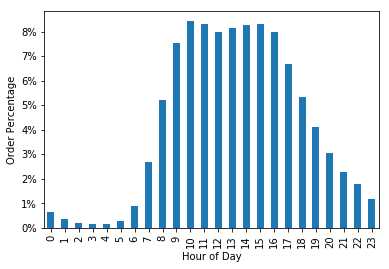

In [12]:
hour_sum = hour_result['count'].sum()
hour_result['count'] /= hour_sum
hour_plot = hour_result['count'].plot(kind='bar')
hour_plot.set_ylabel("Order Percentage")
hour_plot.set_xlabel("Hour of Day")
hour_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#### What day of week do people usually order from Instacart?
Method:  
    SELECT order_dow, count(order_id)  
    FROM orders  
    GROUP BY order_dow  
    ORDER BY order_dow  

In [13]:
day_result = df_orders.groupBy(df_orders.order_dow) \
    .count() \
    .sort(df_orders.order_dow) \
    .toPandas()

In [14]:
def formatDOW(nth_day):
    return {
        0: 'Sat',
        1: 'Sun',
        2: 'Mon',
        3: 'Tue',
        4: 'Wed',
        5: 'Thu',
        6: 'Fri',
    }.get(nth_day, 'Nan')

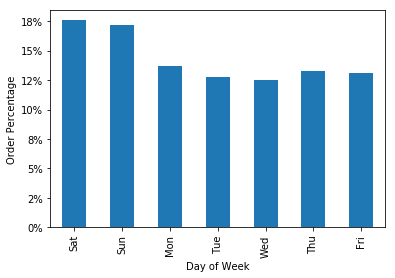

In [15]:
day_sum = day_result['count'].sum()
day_result['count'] /= day_sum
day_plot = day_result['count'].plot(kind='bar')
day_plot.set_ylabel("Order Percentage")
day_plot.set_xlabel("Day of Week")
day_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
day_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: formatDOW(x))) 

#### How often do users order again?
Method:  
    SELECT days_since_prior_order, count(order_id)  
    FROM orders  
    GROUP BY days_since_prior_order  
    ORDER BY days_since_prior_order  

In [16]:
reorder_result = df_orders.groupBy(df_orders.days_since_prior_order) \
    .count() \
    .sort(df_orders.days_since_prior_order) \
    .toPandas()

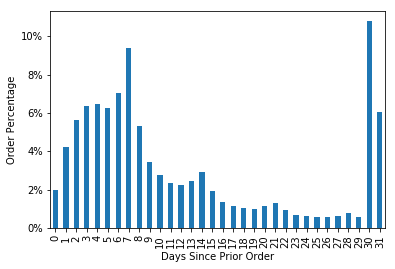

In [17]:
reorder_sum = reorder_result['count'].sum()
reorder_result['count'] /= reorder_sum
reorder_plot = reorder_result['count'].plot(kind='bar')
reorder_plot.set_ylabel("Order Percentage")
reorder_plot.set_xlabel("Days Since Prior Order")
reorder_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#### How many times do users order?

SELECT user_id, max(order_number)

In [18]:
times_result = df_orders.groupBy(df_orders.user_id) \
    .agg({"order_number": "max"}) \
    .withColumnRenamed('max(order_number)', 'total_orders') \
    .selectExpr('10 * FLOOR(total_orders/10.0)', 'user_id') \
    .toDF('total_orders_cat', 'user_id') \
    .groupBy('total_orders_cat') \
    .count() \
    .sort('total_orders_cat')\
    .toPandas()

In [19]:
def formatTotalOrders(x):
    real_x = x * 10
    return {
        0: '(0,10)',
        100: '[100,inf)',
    }.get(real_x, '[%d,%d)' % (real_x, real_x+10))

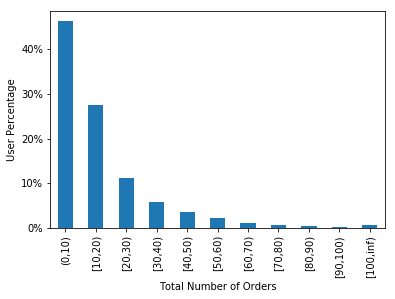

In [20]:
times_sum = times_result['count'].sum()
times_result['count'] /= times_sum
times_plot = times_result.plot(kind='bar', x='total_orders_cat', y='count', legend=False)
times_plot.set_ylabel("User Percentage")
times_plot.set_xlabel("Total Number of Orders")
times_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
times_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: formatTotalOrders(x)))

#### What are the most popular groceries?
SELECT TOP (15) * FROM  
SELECT product_name, COUNT(order_id) as count
FROM order_products  
JOIN products ON order_products.product_id = products.product_id  
GROUPBY products.product_id  
ORDER BY count  

In [21]:
# Find Product IDs of Top 15 BestSelling Products
top15_temp = df_order_detail.groupBy(df_order_detail.product_id) \
    .count() \
    .sort('count', ascending=False) \
    .limit(15)
# Find Product Names    
top15_detail = top15_temp.join(df_products, df_products.product_id == top15_temp.product_id) \
    .select('product_name', 'count') \
    .sort('count', ascending=False) \
    .toPandas()

In [22]:
total_orders = df_order_detail.select('order_id').distinct().count()

In [23]:
def formatProductName(i):
    return top15_detail.product_name[i]

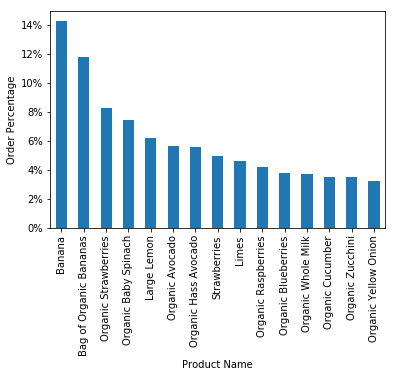

In [24]:
top15_detail['count'] /= total_orders
top15_plot = top15_detail.plot(kind='bar', legend=False)
top15_plot.set_ylabel("Order Percentage")
top15_plot.set_xlabel("Product Name")
top15_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
top15_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: formatProductName(x)))

#### What aisles are reordered most often?
SELECT TOP (15) * FROM  
SELECT aisle, mean(reordered) as reorder_ratio  
FROM order_products  
JOIN products ON order_products.product_id = products.product_id  
JOIN aisles ON products.aisle_id = aisles.aisle_id  
GROUPBY aisle  
ORDER BY reorder_ratio

In [25]:
reorder_rate_temp = df_order_detail.join(df_products, df_products.product_id == df_order_detail.product_id) \
    .groupBy('aisle_id') \
    .agg({"reordered": "mean"}) \
    .withColumnRenamed('avg(reordered)', 'reorder_rate') \
    .sort('reorder_rate', ascending=False) \
    .limit(15)

reorder_rate_result = reorder_rate_temp.join(df_aisles, df_aisles.aisle_id == reorder_rate_temp.aisle_id) \
    .select('aisle', 'reorder_rate') \
    .sort('reorder_rate', ascending=False) \
    .toPandas()

In [26]:
def formatAisleName(i):
    return reorder_rate_result.aisle[i]

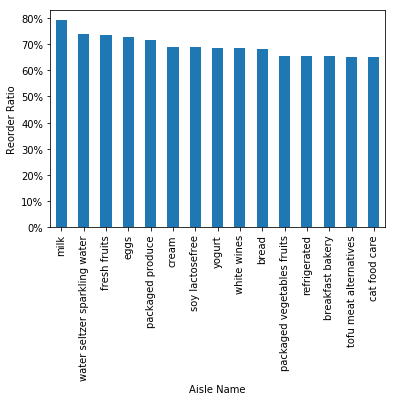

In [27]:
reorder_rate_plot = reorder_rate_result.plot(kind='bar', legend=False)
reorder_rate_plot.set_ylabel("Reorder Ratio")
reorder_rate_plot.set_xlabel("Aisle Name")
reorder_rate_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
reorder_rate_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: formatAisleName(x)))

#### Linear Regression using Add-to-Order to predict reorder ratio

In [32]:
# Prepare Spark DataFrame
order_reorder = df_order_detail.select('add_to_cart_order', 'reordered') \
    .groupBy('add_to_cart_order') \
    .agg({"reordered": "mean"}) \
    .withColumnRenamed('avg(reordered)', 'reorder_ratio') \
    .filter(df_order_detail.add_to_cart_order < 50) \
    .sort('add_to_cart_order')

corr_result = order_reorder.toPandas()

assembler = VectorAssembler(inputCols=["add_to_cart_order"], outputCol="features")
output = assembler.transform(order_reorder)

In [33]:
# Fit linear regression
lr = LinearRegression() \
  .setLabelCol("reorder_ratio")
lrModel = lr.fit(output)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [-0.00607966402266]
Intercept: 0.635881186938825


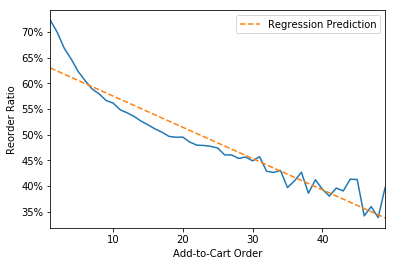

In [34]:
corr_plot = corr_result.plot(x = 'add_to_cart_order', y = 'reorder_ratio', label = 'Real Value')
prediction_values = [lrModel.coefficients * i + lrModel.intercept for i in corr_result.add_to_cart_order]
prediction = plt.plot(corr_result.add_to_cart_order, prediction_values, label='Regression Prediction', linestyle='--')
corr_plot.set_ylabel("Reorder Ratio")
corr_plot.set_xlabel("Add-to-Cart Order")
plt.legend(handles = prediction)
corr_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#### What aisles are frequenly bought together?

In [107]:
# Prepare Spark DataFrame
order_aisle = df_order_detail.join(df_products, df_products.product_id == df_order_detail.product_id) \
    .join(df_aisles, df_aisles.aisle_id == df_products.aisle_id) \
    .select(df_order_detail.order_id, df_aisles.aisle) \
    .filter("aisle NOT LIKE '%fruits' AND aisle NOT LIKE '%vegetables'") \
    .dropDuplicates() \
    .persist()

In [108]:
print('Before transformation:')
order_aisle.show(10)

Before transformation:
+--------+------+
|order_id| aisle|
+--------+------+
| 3236948|coffee|
| 3334306|coffee|
| 2833450|coffee|
| 1807947|coffee|
| 1328800|coffee|
|    4468|coffee|
| 3163338|coffee|
| 2483455|coffee|
| 1966767|coffee|
|  761521|coffee|
+--------+------+
only showing top 10 rows



In [109]:
transactions = order_aisle.groupBy(order_aisle.order_id) \
    .agg({'aisle' : 'collect_list'}) \
    .withColumnRenamed('collect_list(aisle)', 'items') \
    .persist()

In [110]:
print('After transformation:')
transactions.show(5, truncate=100)

After transformation:
+--------+----------------------------------------------------------------------------------------------------+
|order_id|                                                                                               items|
+--------+----------------------------------------------------------------------------------------------------+
|    3091|                                                     [nuts seeds dried fruit, tea, breakfast bakery]|
|    4590|     [energy granola bars, frozen meals, fresh dips tapenades, trail mix snack mix, packaged cheese]|
|   10156|[packaged cheese, yogurt, pasta sauce, breakfast bakery, frozen vegan vegetarian, dry pasta, soy ...|
|   13248|[soup broth bouillon, pasta sauce, tea, cereal, frozen meals, fresh dips tapenades, frozen appeti...|
|   16530|                      [refrigerated, asian foods, juice nectars, fresh herbs, prepared soups salads]|
+--------+------------------------------------------------------------------------

In [111]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0)
model = fpGrowth.fit(transactions)

In [114]:
# Display frequent itemsets.
model.freqItemsets.show(truncate=100)

+------------------------------------------------+-----+
|                                           items| freq|
+------------------------------------------------+-----+
|                                        [yogurt]|33249|
|                               [packaged cheese]|31199|
|                       [packaged cheese, yogurt]|11548|
|                                          [milk]|29358|
|                         [milk, packaged cheese]|10013|
|                                  [milk, yogurt]|11414|
|                 [water seltzer sparkling water]|26943|
|[water seltzer sparkling water, packaged cheese]| 6944|
|         [water seltzer sparkling water, yogurt]| 7632|
|                                [chips pretzels]|23182|
|               [chips pretzels, packaged cheese]| 7994|
|                        [chips pretzels, yogurt]| 7638|
|                               [soy lactosefree]|22373|
|                       [soy lactosefree, yogurt]| 7680|
|                              

In [115]:
# Display generated association rules.
model.associationRules.sort('confidence', ascending=False).show(50, truncate=100)

+-------------------------------+-------------------------------+-------------------+
|                     antecedent|                     consequent|         confidence|
+-------------------------------+-------------------------------+-------------------+
|                   [lunch meat]|              [packaged cheese]|0.45711678832116787|
|                         [milk]|                       [yogurt]|0.38878670209142313|
|                        [bread]|              [packaged cheese]| 0.3750465376023827|
|                        [bread]|                       [yogurt]| 0.3703462397617275|
|              [packaged cheese]|                       [yogurt]|0.37014006859194204|
|                         [eggs]|                       [yogurt]| 0.3622079801529874|
|                        [bread]|                         [milk]|0.34814780342516755|
|                         [eggs]|              [packaged cheese]| 0.3477878850527186|
|                       [yogurt]|              [packag